## **Corrective RAG**

Corrective Retrieval-Augmented Generation (Corrective RAG or CRAG) is a method that improves the accuracy of generated responses by evaluating and correcting retrieved documents before using them. It works as follows:

**Correct:** If documents are relevant, they are refined to remove unnecessary parts and used for generation.

**Incorrect:** If documents are irrelevant, they are discarded, and the system retrieves additional information, like using web search.
(**Note:** In our case, we are not performing this step.)

**Ambiguous:** If it's unclear, the system combines retrieved and web-searched information for a balanced response.

Research Paper: [Corrective RAG](https://arxiv.org/pdf/2401.15884)

## **Initial Setup**

In [ ]:
! pip install --q athina chromadb langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.5/83.5 kB 2.7 MB/s eta 0:00:00


In [ ]:
# ! pip install --q athina datasets langchain_community tiktoken langchain-openai langchainhub chromadb langchain langgraph tavily-python

In [ ]:
import os
from google.colab import userdata
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
os.environ["TAVILY_API_KEY"] = userdata.get('TAVILY_API_KEY')
os.environ['ATHINA_API_KEY'] = userdata.get('ATHINA_API_KEY')

## **Indexing**

In [ ]:
# load embedding model
from langchain_openai import OpenAIEmbeddings
embeddings = OpenAIEmbeddings()

In [ ]:
# load data
from langchain.document_loaders import CSVLoader
loader = CSVLoader("./context.csv")
documents = loader.load()

In [ ]:
# split documents
from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=0)
documents = text_splitter.split_documents(documents)

In [ ]:
# create vectorstore
from langchain.vectorstores import Chroma
vectorstore = Chroma.from_documents(documents, embeddings)

## **Retriever**

In [ ]:
# create retriever
retriever = vectorstore.as_retriever()

## **Document Grader**
The document grader evaluates whether a document is relevant to the given query.

In [ ]:
# create grader for doc retriever
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI

# defining a data class for the grader
class GradeDocuments(BaseModel):
    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )

# LLM with function call
llm = ChatOpenAI(temperature=0)
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Prompt for the grader
system = """You are a grader assessing relevance of a retrieved document to a user question. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/beta_decorator.py:87: LangChainBetaWarning: The method `ChatOpenAI.with_structured_output` is in beta. It is actively being worked on, so the API may change.
  warn_beta(


In [ ]:
# run grader
question = "how does interlibrary loan work"
docs = retriever.get_relevant_documents(question)
print(retrieval_grader.invoke({"question": question, "document": docs}))

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


binary_score='yes'


## **RAG Chain**

In [ ]:
# create document chain
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain.prompts import ChatPromptTemplate

template = """"
You are a helpful assistant that answers questions based on the following context.'
Use the provided context to answer the question.
Context: {context}
Question: {question}
Answer:

"""

prompt = ChatPromptTemplate.from_template(template)
llm = ChatOpenAI(temperature=0)

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


rag_chain = prompt | llm | StrOutputParser()

In [ ]:
# response
generation = rag_chain.invoke({"context": docs, "question": question})
generation

'Interlibrary loan (ILL) is a service that allows patrons of one library to borrow physical materials or receive electronic documents from another library. After receiving a request from a patron, the borrowing library identifies potential lending libraries with the desired item. The lending library then delivers the item physically or electronically to the borrowing library, who then delivers it to their patron. If necessary, arrangements are made for the return of the item. Fees may accompany interlibrary loan services, and the majority of requests are now managed through semi-automated systems. Libraries negotiate for ILL eligibility, and with the increasing demand for digital materials, they are exploring the legal, technical, and licensing aspects of lending and borrowing ebooks through interlibrary loan.'

## **Web Search**

In [ ]:
# define web search
from langchain_community.tools.tavily_search import TavilySearchResults
web_search_tool = TavilySearchResults(k=3)

In [ ]:
# # sample web search
# web_search_tool.invoke('USA election 2024')

## **Create Graph**

### **Define Graph State**

In [ ]:
# define a data class for state
from typing import List
from typing_extensions import TypedDict

class GraphState(TypedDict):
    question: str
    generation: str
    web_search: str
    documents: List[str]

### **Build Graph**

In [ ]:
# define graph steps
from langchain.schema import Document

# node function for retrieval
def retrieve(state):

    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}

# node function for generation
def generate(state):

    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}

# node function for check_relevance
def grade_documents(state):

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    web_search = "No"
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            web_search = "Yes"
            continue
    return {"documents": filtered_docs, "question": question, "web_search": web_search}


# node function for web search
def web_search(state):

    print("---WEB SEARCH---")
    question = state["question"]
    documents = state["documents"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)

    return {"documents": documents, "question": question}

# node function for decision
def decide_to_generate(state):

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    web_search = state["web_search"]
    state["documents"]

    if web_search == "Yes":
        print("---DECISION: WEB SEARCH---")
        return "web_search"
    else:
        print("---DECISION: GENERATE---")
        return "generate"

In [ ]:
# Build graph
from langgraph.graph import END, StateGraph, START

# Graph
workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("web_search_node", web_search)  # web search

# Build graph
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "web_search": "web_search_node",
        "generate": "generate",
    },
)

workflow.add_edge("web_search_node", "generate")
workflow.add_edge("generate", END)

# Compile
app = workflow.compile()

In [ ]:
# example 1 where documents are relevant
from pprint import pprint

inputs = {"question": "how does interlibrary loan work"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Node '{key}':")
    pprint("\n---\n")


pprint(value["generation"])

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
"Node 'grade_documents':"
'\n---\n'
---GENERATE---
"Node 'generate':"
'\n---\n'
('Interlibrary loan works by allowing patrons of one library to borrow '
 'physical materials or receive electronic documents from another library that '
 'holds the desired item. The borrowing library identifies potential lending '
 'libraries, which then deliver the item either physically or electronically. '
 'The borrowing library receives the item, delivers it to their patron, and '
 'arranges for its return if necessary. Fees may accompany interlibrary loan '
 'services, and the majority of requests are now managed through '
 'semi-automated systems.')


In [ ]:
# example 2 where documents are not relevant
from pprint import pprint

inputs = {"question": "What is Retrieval-Augmented Generation (RAG)?"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Node '{key}':")
    pprint("\n---\n")

pprint(value["generation"])

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: WEB SEARCH---
"Node 'grade_documents':"
'\n---\n'
---WEB SEARCH---
"Node 'web_search_node':"
'\n---\n'
---GENERATE---
"Node 'generate':"
'\n---\n'
('Retrieval-Augmented Generation (RAG) is a technique that enhances generative '
 'artificial intelligence models by allowing them to access and reference '
 'external knowledge bases, such as specific documents or databases, before '
 'generating a response. This process helps improve the relevance and accuracy '
 "of the generated text by incorporating information beyond the model's own "
 'training data.')


## **Preparing Data for Evaluation**

In [ ]:
# Create a dataframe to store the question, context, and response
inputs = {"question": "what are points on a mortgage?"}
outputs = []
expected_response = "Points, sometimes also called a 'discount point', are a form of pre-paid interest ."

for output in app.stream(inputs):
    for key, value in output.items():
        if key == "generate":
            question = value["question"]
            documents = value["documents"]
            generation = value["generation"]

            context = "\n".join(doc.page_content for doc in documents)

            # Append the result
            outputs.append({
                "query": question,
                "context": context,
                "response": generation,
                "expected_response": expected_response
            })


---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
---GENERATE---


In [ ]:
# Convert to DataFrame
import pandas as pd
df = pd.DataFrame(outputs)

In [ ]:
df

,query,context,response,expected_response
0,what are points on a mortgage?,"context: [""Discount points, also called mortgage points or simply points, are a form of pre-paid interest available in the United States when arranging a mortgage. One point equals one percent of the loan amount. By charging a borrower points, a lender effectively increases the yield on the loan above the amount of the stated interest rate. Borrowers can offer to pay a lender points as a method to reduce the interest rate on the loan, thus obtaining a lower monthly payment in exchange for t...","Points on a mortgage, also known as discount points, are a form of pre-paid interest that borrowers can pay to lenders in order to reduce the interest rate on the loan. One point equals one percent of the loan amount. By paying points, borrowers can obtain a lower monthly payment in exchange for this upfront payment. Points can also be used to reduce the monthly payment for the purpose of qualifying for a loan based on monthly income. It is important to note that points are different from or...","Points, sometimes also called a 'discount point', are a form of pre-paid interest ."


In [ ]:
# Convert to dictionary
df_dict = df.to_dict(orient='records')

# Convert context to list
for record in df_dict:
    if not isinstance(record.get('context'), list):
        if record.get('context') is None:
            record['context'] = []
        else:
            record['context'] = [record['context']]

## **Evaluation in Athina AI**

We will use **Context Precision** eval here. It Evaluates whether all of the ground-truth relevant items present in the contexts are ranked higher or not. Please refer to our [documentation](https://docs.athina.ai/api-reference/evals/preset-evals/overview) for further details.

In [ ]:
# set api keys for Athina evals
from athina.keys import AthinaApiKey, OpenAiApiKey
OpenAiApiKey.set_key(os.getenv('OPENAI_API_KEY'))
AthinaApiKey.set_key(os.getenv('ATHINA_API_KEY'))

In [ ]:
# load dataset
from athina.loaders import Loader
dataset = Loader().load_dict(df_dict)

In [ ]:
# evaluate
from athina.evals import RagasContextPrecision
RagasContextPrecision(model="gpt-4o").run_batch(data=dataset).to_df()

evaluating with [context_precision]


100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


You can view your dataset at: https://app.athina.ai/develop/2c0c4475-a30e-4d2c-92f9-c57f494ba947


,query,context,response,expected_response,display_name,failed,grade_reason,runtime,model,ragas_context_precision
0,what are points on a mortgage?,"[context: [""Discount points, also called mortgage points or simply points, are a form of pre-paid interest available in the United States when arranging a mortgage. One point equals one percent of the loan amount. By charging a borrower points, a lender effectively increases the yield on the loan above the amount of the stated interest rate. Borrowers can offer to pay a lender points as a method to reduce the interest rate on the loan, thus obtaining a lower monthly payment in exchange for ...","Points on a mortgage, also known as discount points, are a form of pre-paid interest that borrowers can pay to lenders in order to reduce the interest rate on the loan. One point equals one percent of the loan amount. By paying points, borrowers can obtain a lower monthly payment in exchange for this upfront payment. Points can also be used to reduce the monthly payment for the purpose of qualifying for a loan based on monthly income. It is important to note that points are different from or...","Points, sometimes also called a 'discount point', are a form of pre-paid interest .",Ragas Context Precision,None,This metric evaluates whether all of the ground-truth relevant items present in the context are ranked higher or not. Ideally all the relevant chunks must appear at the top ranks,1674,gpt-4o,1.0


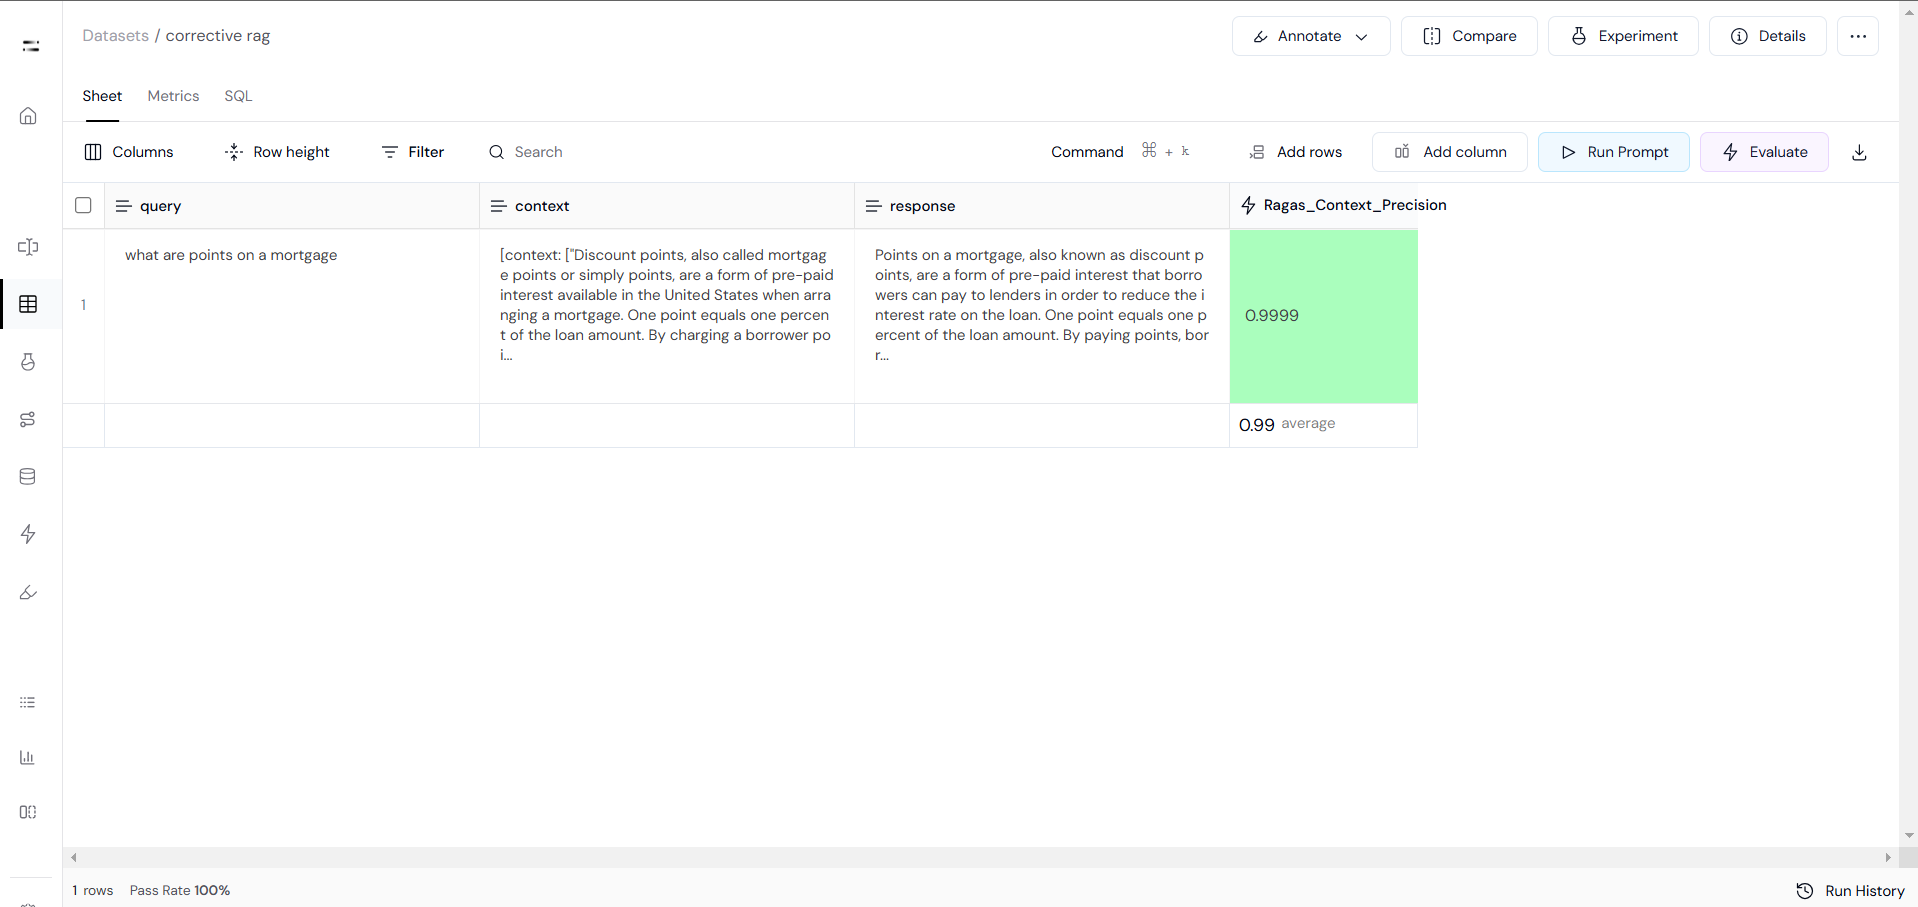